In [1]:
from PIL import Image
import torch as th
import os

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [2]:
def init_cuda_device_options():
    has_cuda = th.cuda.is_available()
    device = th.device('cuda' if has_cuda else 'cpu')
    options = model_and_diffusion_defaults()
    options['use_fp16'] = has_cuda
    options['timestep_respacing'] = '100'
    return has_cuda, device, options


In [3]:
has_cuda, device, options = init_cuda_device_options()
model, diffusion = create_model_and_diffusion(**options)

In [4]:
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(th.load('glide_model_cache/base.pt'))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [5]:
print(th.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     806 MB |     806 MB |     806 MB |       0 B  |
|       from large pool |     765 MB |     765 MB |     765 MB |       0 B  |
|       from small pool |      40 MB |      40 MB |      40 MB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |     806 MB |     806 MB |     806 MB |       0 B  |
|       from large pool |     765 MB |     765 MB |     765 MB |

In [23]:
# Create a classifier-free guidance sampling function
th.cuda.empty_cache()

prompt = "Godzilla fighting King Kong"
num_variations = 4

guidance_scale = 6.0
upsample_temp = 0.997

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])
full_batch_size = num_variations *2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask([], options['text_ctx'])
model_kwargs = dict(
    tokens = th.tensor([tokens] * num_variations + [uncond_tokens] * num_variations, device = device),
    mask = th.tensor([mask] * num_variations + [uncond_mask] * num_variations, device=device, dtype=th.bool),
)

def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) //2]
    combined = th.cat([half, half], dim = 0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim = 0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim = 0)
    return th.cat([eps, rest], dim = 1)

In [24]:
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options['image_size'], options['image_size']),
    device = device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None
)[:num_variations]
model.del_cache()

scaled: th.Tensor =( (samples + 1) * 127.5).round().clamp(0,255).to(th.uint8).cpu()
reshaped = scaled.permute(2, 0, 3, 1).reshape([samples.shape[2], -1, 3])
print(
    samples.size(),
    scaled.size(),
    reshaped.size(),
    reshaped.numpy().shape
)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([4, 3, 64, 64]) torch.Size([4, 3, 64, 64]) torch.Size([64, 256, 3]) (64, 256, 3)


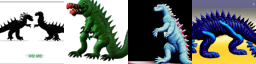

In [25]:
Image.fromarray(reshaped.numpy())

In [26]:
foo = reshaped.numpy()
print(foo.shape)

(64, 256, 3)


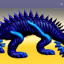

In [27]:
bar = foo[:64, 64*3:64*4, :]
Image.fromarray(bar)


In [28]:
print(bar)

[[[104 103 141]
  [104 103 141]
  [104 103 141]
  ...
  [104 103 141]
  [104 103 140]
  [104 103 141]]

 [[104 103 141]
  [104 103 140]
  [104 103 140]
  ...
  [104 103 140]
  [103 103 140]
  [104 103 140]]

 [[104 103 140]
  [104 103 140]
  [104 103 140]
  ...
  [104 102 139]
  [104 103 141]
  [104 103 140]]

 ...

 [[255 216  59]
  [255 216  60]
  [255 216  60]
  ...
  [255 216  60]
  [255 216  60]
  [254 216  60]]

 [[255 217  60]
  [255 217  60]
  [255 216  60]
  ...
  [255 216  61]
  [254 216  61]
  [254 216  60]]

 [[255 218  59]
  [255 217  60]
  [255 217  60]
  ...
  [255 217  61]
  [255 217  61]
  [255 217  60]]]
